<a href="https://colab.research.google.com/github/kay-kay-t/Number-of-Likes-Prediction-Project/blob/main/Project2_Video_Content_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source of data
[Kaggle](https://www.kaggle.com/prokaggler/video-popularity-prediction)

# Brief description of data

One of datasets from Kaggle, that has different features of video. I can make some predictions on different features based on other features video has. For exaple, I can make  prediction on how many likes video can get or how likely it will have a partner.

* compid: Unique ID 
* adblocked: Indicates whether or not ads are blocked on the video
* embed: Indicates whether or not the video can be embedded
* ratio: The aspect ratio of the video
* duration: Duration of the video (in seconds)
* language: Language used in the video (encoded)
* partner: Indicates whether the video is certified by the partner/sponsor
* partneractive: Indicates whether the partner/sponsor is still active 
* nlikes: The number of likes the video has
* ntags: The number of tags in the video nformats: The number of streaming 
* formats available for the video
* dayofweek: The day of week when the video was published
* hour: The hour when the video was published (24-hour time format)

In [60]:
# Imports 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

## Part 1: Data cleaning & exploration

In [61]:
# Load data 
df = pd.read_csv('/content/drive/MyDrive/Data/public_meta_df.csv')
df.head()

,comp_id,ad_blocked,embed,ratio,duration,language,partner,partner_active,n_likes,n_tags,n_formats,dayofweek,hour
0,3001,False,True,1.33333,1675,2,False,False,0,10,2,2,3
1,3002,False,True,1.33333,1479,2,False,False,0,10,2,2,3
2,3003,False,True,1.33333,1505,2,False,False,0,10,2,2,3
3,3004,False,True,1.77778,50,2,True,True,1,6,5,2,3
4,3005,False,True,1.33333,1543,2,False,False,0,6,2,2,3


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comp_id         986 non-null    int64  
 1   ad_blocked      986 non-null    bool   
 2   embed           986 non-null    bool   
 3   ratio           986 non-null    float64
 4   duration        986 non-null    int64  
 5   language        986 non-null    int64  
 6   partner         986 non-null    bool   
 7   partner_active  986 non-null    bool   
 8   n_likes         986 non-null    int64  
 9   n_tags          986 non-null    int64  
 10  n_formats       986 non-null    int64  
 11  dayofweek       986 non-null    int64  
 12  hour            986 non-null    int64  
dtypes: bool(4), float64(1), int64(8)
memory usage: 73.3 KB


In [63]:
df.shape

(986, 13)

In [64]:
# Checking if there any duplicates
df.duplicated().any()

False

In [65]:
# Checking for missing values
df.isnull().sum()

comp_id           0
ad_blocked        0
embed             0
ratio             0
duration          0
language          0
partner           0
partner_active    0
n_likes           0
n_tags            0
n_formats         0
dayofweek         0
hour              0
dtype: int64

In [66]:
# Using for loop to check all data frame for inconsistent values
for col in df.columns:
    print(df[col].value_counts())

3986    1
3339    1
3337    1
3336    1
3335    1
       ..
3653    1
3652    1
3651    1
3650    1
3001    1
Name: comp_id, Length: 986, dtype: int64
False    986
Name: ad_blocked, dtype: int64
True     952
False     34
Name: embed, dtype: int64
1.77778    399
1.33333    300
1.72414     57
1.76471     37
1.22222     31
1.76667     29
1.25000     16
2.28571     14
1.48148     11
1.73913      9
1.48837      9
1.77273      7
1.80000      7
1.76000      6
1.81818      6
1.60000      6
1.73077      4
2.46154      4
1.50000      4
2.35294      3
1.46667      3
1.00000      2
1.52381      2
1.34091      2
1.35714      2
1.79412      2
1.74194      1
1.34783      1
1.31667      1
1.72973      1
1.31579      1
1.78261      1
1.30769      1
1.78571      1
1.18889      1
1.45455      1
1.75000      1
1.51111      1
1.30000      1
1.34483      1
Name: ratio, dtype: int64
2343    13
2342    10
44       8
86       8
41       8
        ..
485      1
486      1
1511     1
488      1
1039     1
Name: 

In [67]:
# Looks likie we can drop ad_blocked as well since they are all False, so it would not have any impact on likes
df['ad_blocked'].value_counts()

False    986
Name: ad_blocked, dtype: int64

In [68]:
# I think we can drop partner_active column as well
df.drop(columns=['partner_active', 'ad_blocked'], inplace=True)
df.head()

,comp_id,embed,ratio,duration,language,partner,n_likes,n_tags,n_formats,dayofweek,hour
0,3001,True,1.33333,1675,2,False,0,10,2,2,3
1,3002,True,1.33333,1479,2,False,0,10,2,2,3
2,3003,True,1.33333,1505,2,False,0,10,2,2,3
3,3004,True,1.77778,50,2,True,1,6,5,2,3
4,3005,True,1.33333,1543,2,False,0,6,2,2,3


I am going to set number of likes as my target. Let's see thedestribution of likes.

In [69]:
df['n_likes'].value_counts()

0    921
1     47
2     12
3      5
6      1
Name: n_likes, dtype: int64

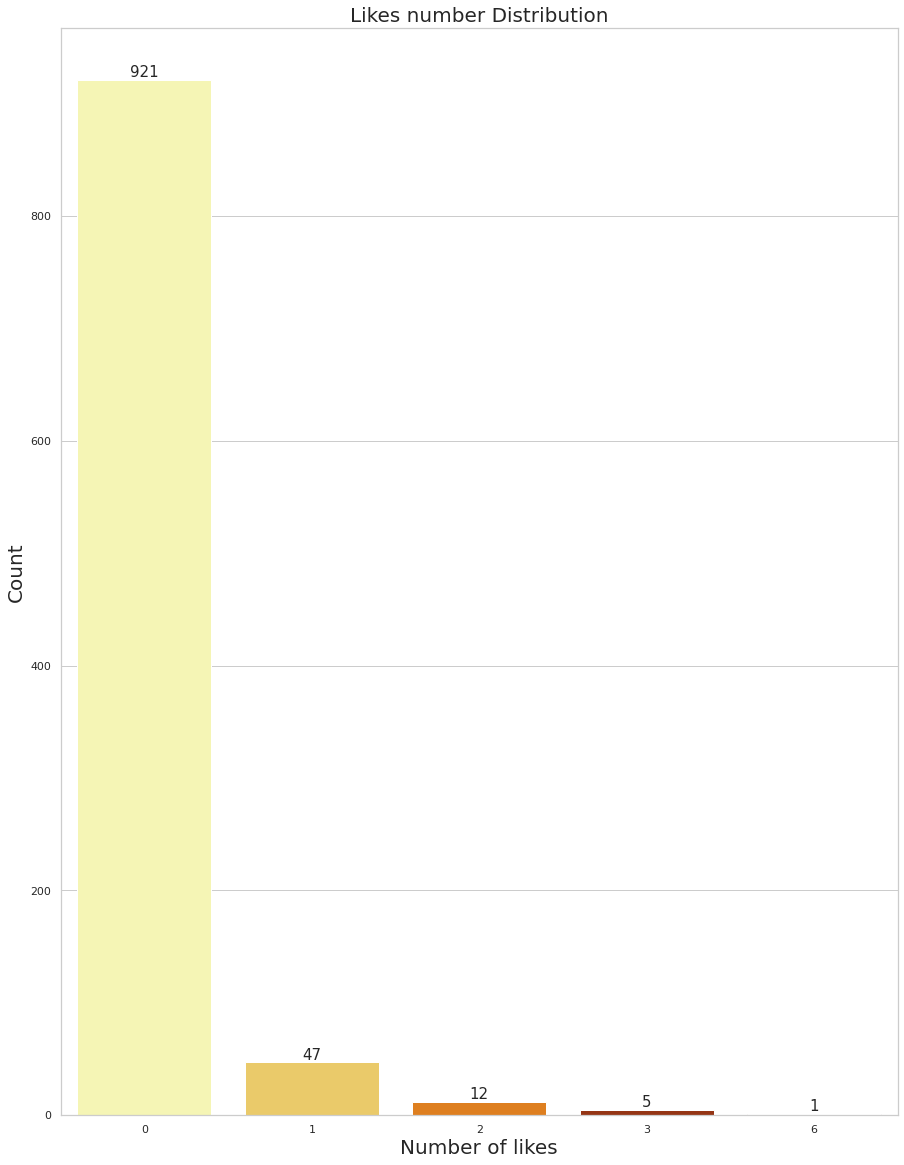

This histogram shows that videos with no likes are highly overbalance the other ones with any amount of likes.


In [70]:
# Histogram that shows Number of Likes Distidution
sns.countplot(data=df, x='n_likes',
              palette='afmhot_r');
  

plt.xlabel('Number of likes', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Likes number Distribution', fontsize=20)


ax=plt.gca()

for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), ha='center', va='bottom', fontsize=15)

plt.show()
print('This histogram shows that videos with no likes are highly overbalance the other ones with any amount of likes.')


Based on visualization above it makes sense grouping videos by the ones that have 0 likes and the ones with any likes, since there's a big amount of first ones to the second ones. We can see what videos are unpopuloar comparing to the ones that got some interaction and how other fetures affectiong likes.

In [71]:
df['n_likes'].value_counts()

0    921
1     47
2     12
3      5
6      1
Name: n_likes, dtype: int64

In [72]:
# Binarize target column 
df['n_likes'] = df['n_likes'].replace([2, 3, 6], 1)
df.head()

,comp_id,embed,ratio,duration,language,partner,n_likes,n_tags,n_formats,dayofweek,hour
0,3001,True,1.33333,1675,2,False,0,10,2,2,3
1,3002,True,1.33333,1479,2,False,0,10,2,2,3
2,3003,True,1.33333,1505,2,False,0,10,2,2,3
3,3004,True,1.77778,50,2,True,1,6,5,2,3
4,3005,True,1.33333,1543,2,False,0,6,2,2,3


Now we can see how other features affect number of likes. First, lets see how an hour of video being posted affect the likes, since usually there's higher level of engagement at certain times.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


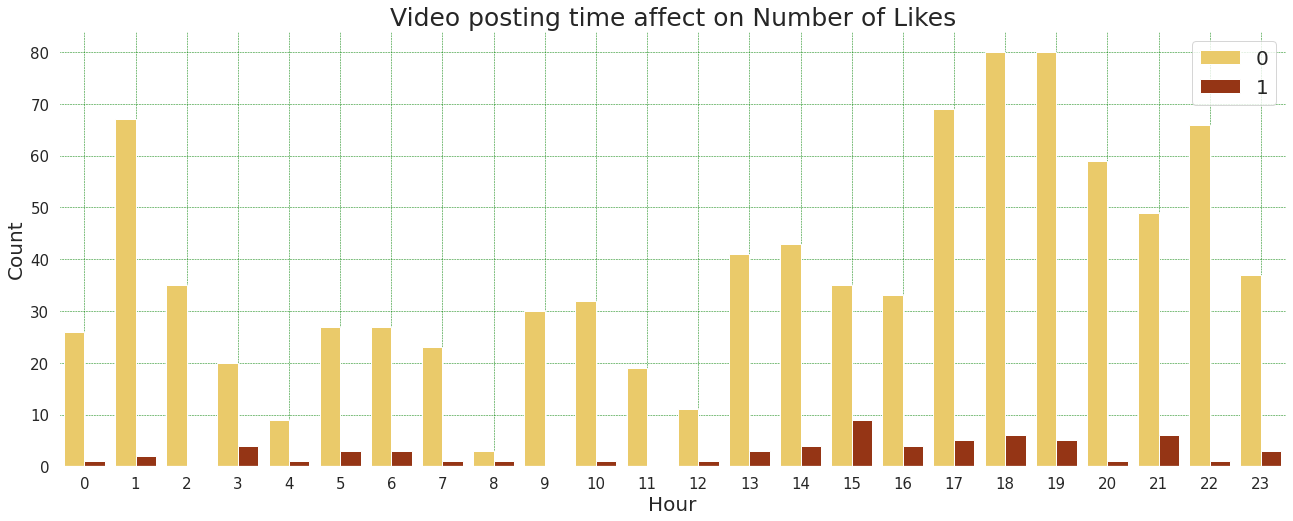

In [73]:
# Creating countplot with Seaborn to see how hour affect number of likes


sns.set(rc={'figure.figsize':(22,8), 'axes.facecolor':'white'})
sns.countplot('hour', hue='n_likes', data=df,
              palette='afmhot_r');

plt.title('Video posting time affect on Number of Likes', fontsize = 25)  

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.xlabel('Hour', fontsize=20)
plt.ylabel('Count', fontsize=20)

plt.legend(fontsize=20)

plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

# Creating labels (from https://www.youtube.com/watch?v=NIy90kwN4n4)
# ax=plt.gca()

# for p in ax.patches:
#   ax.text(p.get_x()+p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), ha='center', va='bottom', fontsize=15)

plt.show()  

Per visualization above, we see that video has more chances on getting 0 likes at 1 am and between 5 & 7 pm. The highes amount of likes video gets between 3 and 4 pm. 

Text(0.5, 1.0, 'Likes based on Video Duration')

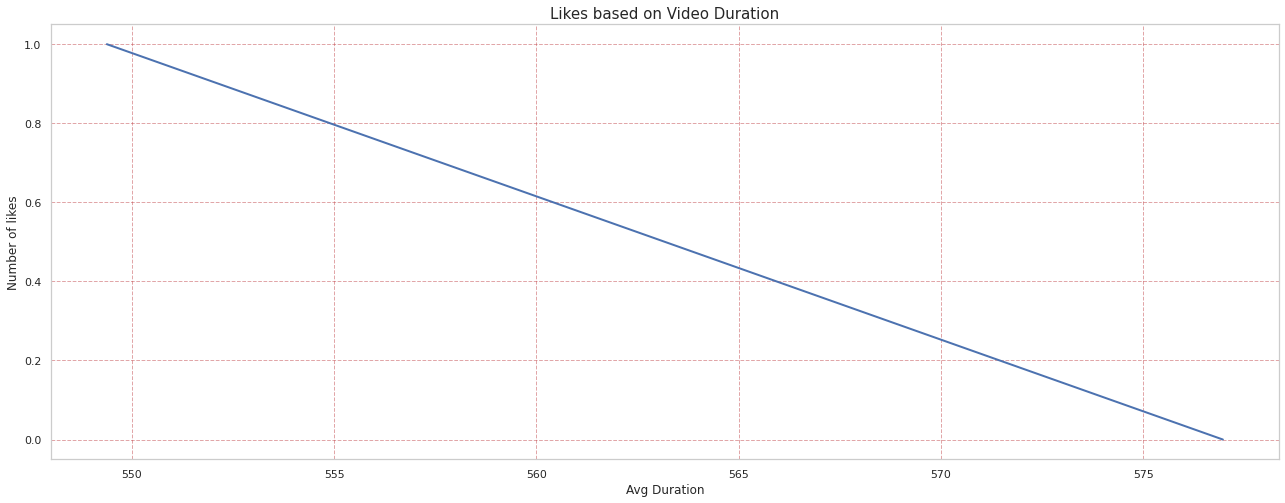

In [74]:
# Number of likes depemding on Duration of the video 
sns.set_style("whitegrid")
drt = df.groupby('n_likes')['duration'].mean().reset_index(name = 'Avg Duration').sort_values('Avg Duration', ascending = False)
plt.plot(drt['Avg Duration'], drt['n_likes'], linewidth=2);

plt.grid(axis='both', color='r', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Avg Duration')
plt.ylabel('Number of likes')
plt.title('Likes based on Video Duration', fontsize=15)

This graph shows that amount of likes dropping with growth of video duration, therefore the longer the video the less lkies it gets.

How, we can see how Day of the Week affect Number of Likes.

In [75]:
 # Grouping by dayofweek and likes
 dof =(
    df
 .groupby('n_likes')
 .dayofweek
 .value_counts()
 .unstack()
 .fillna(0)
 )
dof

dayofweek,1,2,6,7
n_likes,,,,
0,397,75,342,107
1,17,3,37,8


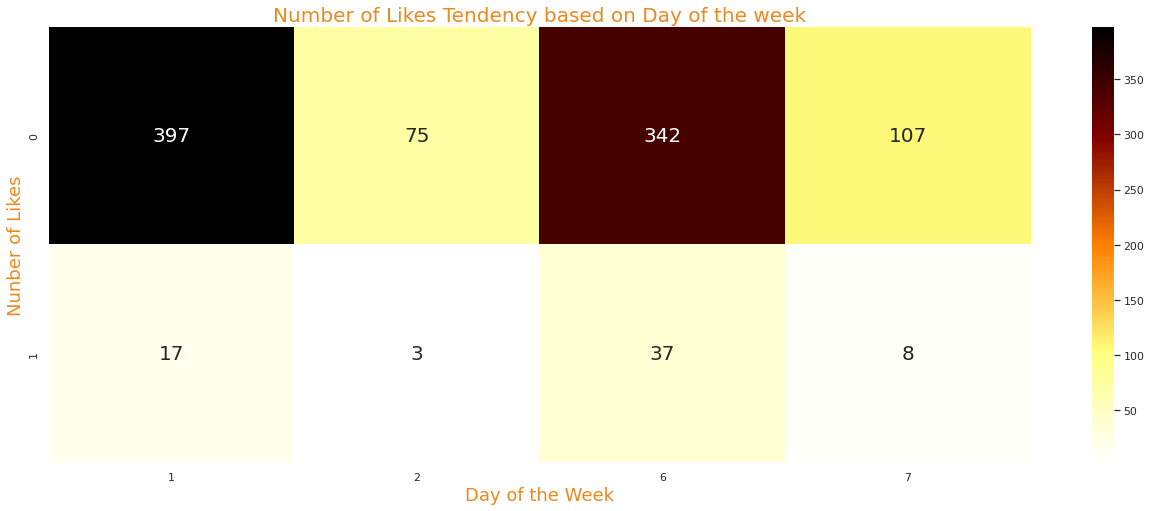

In [76]:
sns.heatmap(dof, 
            cmap='afmhot_r', 
            annot=True, 
            fmt='.0f',
            annot_kws={
                'fontsize':20
            });
         

plt.title('Number of Likes Tendency based on Day of the week', color='#ed881c', fontsize = 20)  
plt.xlabel('Day of the Week', color='#ed881c', fontsize=18)
plt.ylabel('Nunber of Likes', color='#ed881c', fontsize=18)

plt.show()            


Based on this heatmap, videos have more chances on receiving 0 likes on 1st day of the week (Sunday) and 6th day (Friday), however there's high chance on getting likes on 6th day as well.

Text(0.5, 1.0, 'Likes based on Video Ratio')

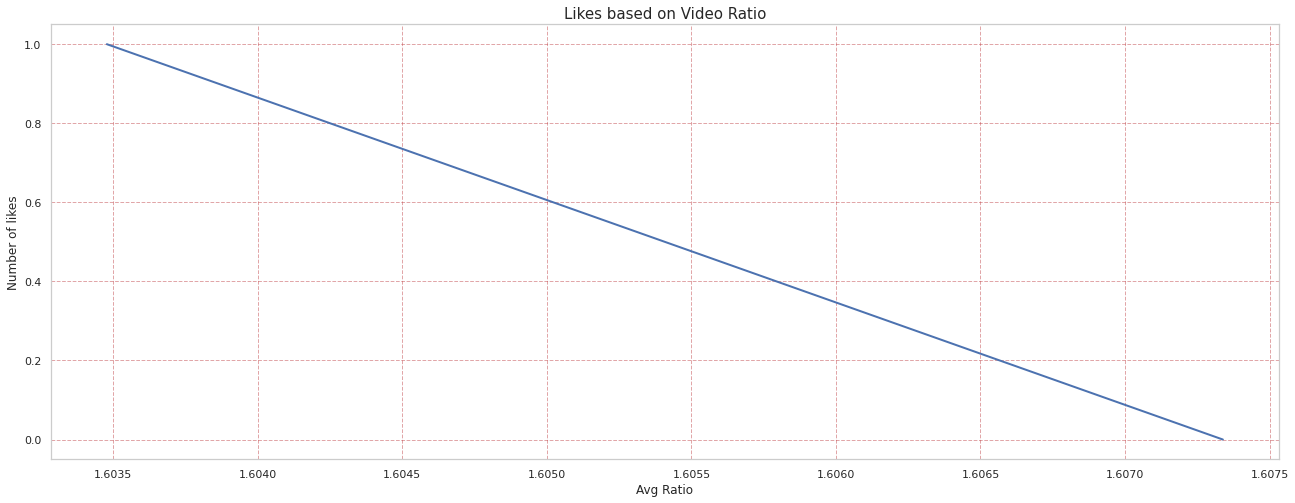

In [77]:
# Number of likes depemding on Duration of the video 
sns.set_style("whitegrid")
rat = df.groupby('n_likes')['ratio'].mean().reset_index(name = 'Avg Ratio').sort_values('Avg Ratio', ascending = False)
plt.plot(rat['Avg Ratio'], rat['n_likes'], linewidth=2);

plt.grid(axis='both', color='r', linestyle='--', linewidth=1, alpha=0.5)

plt.xlabel('Avg Ratio')
plt.ylabel('Number of likes')
plt.title('Likes based on Video Ratio', fontsize=15)

This graph shows that number of likes drops with ratio growth.

Now I'm going to binarize all colums, so I can use different models on them and also see the correlation in dataset.

In [78]:
# Binarize other bool values in columns
a = df['embed'].astype(int)
b = df['partner'].astype(int)
df['embed'] = a
df['partner'] = b
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   comp_id    986 non-null    int64  
 1   embed      986 non-null    int64  
 2   ratio      986 non-null    float64
 3   duration   986 non-null    int64  
 4   language   986 non-null    int64  
 5   partner    986 non-null    int64  
 6   n_likes    986 non-null    int64  
 7   n_tags     986 non-null    int64  
 8   n_formats  986 non-null    int64  
 9   dayofweek  986 non-null    int64  
 10  hour       986 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 84.9 KB


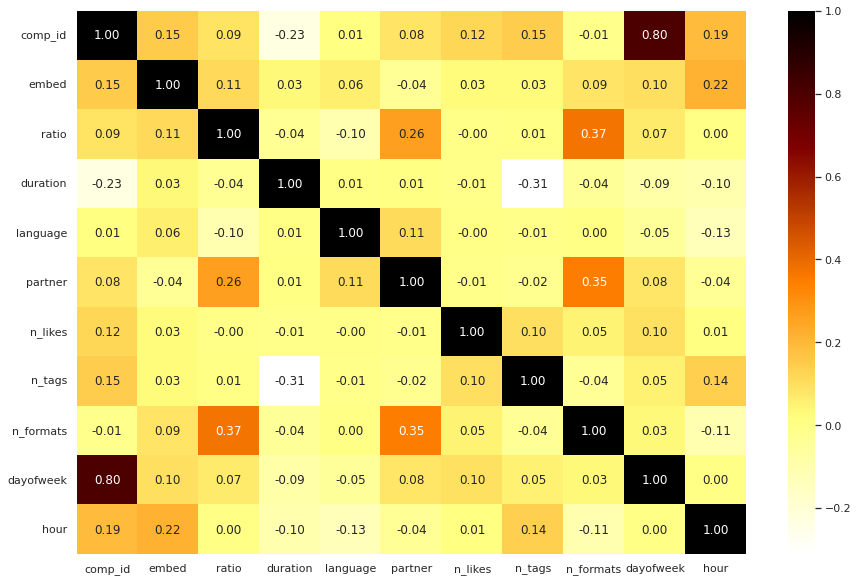

In [79]:
# Heatmap showing correlations 
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), cmap = 'afmhot_r', annot=True, fmt='.02f', ax=ax)

This heatmap shows that number of tags and day of the week has the most impact on number of likes.

In [80]:
# sns.pairplot(df, palette='afmhot_r')
 
 

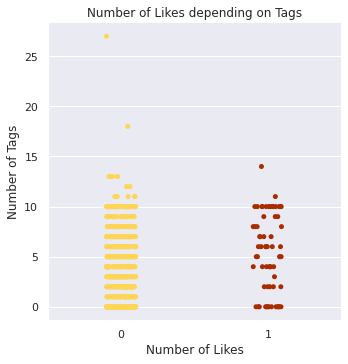

In [81]:
sns.set(rc={'figure.figsize':(15,20)})
sns.catplot(x = 'n_likes', y = 'n_tags', data = df,
                palette="afmhot_r")
sns.set_style("whitegrid")


plt.xlabel('Number of Likes')
plt.ylabel('Number of Tags')
plt.title('Number of Likes depending on Tags');


plt.show()

Per this visualization, most of values are concentrated between 0 and 10 tags. There’s some with 18 Tags and more then 25, which are probably outliers.

## Part 2. Machine Learning

**Logistic Regression**

In [82]:
# Settung target and features
y = df['n_likes']
X = df.drop(columns = 'n_likes')

In [83]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [84]:
# Make an instance of the model
logreg = LogisticRegression(C = 1)

In [85]:
# Scaling logistic regression
scaler = StandardScaler()

scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Training the model on the data
logreg.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
# Checking the scores
print('Training accuracy:', logreg.score(X_train, y_train))
print('Test accuracy:', logreg.score(X_test, y_test))

Training accuracy: 0.9336941813261164
Test accuracy: 0.9352226720647774


Logistic Regression gives pretty good scores with minimum overfitting. I will try to tune some params next to see if it's going to improve the scores.

In [87]:
# Creating a dictionar with all params we'd like to tune
logreg_params = {'penalty' : ['l1', 'l2'],
                 'C' : [1, 25, 50, 100],
                 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 'multi_class' : ['ovr', 'multinomial']}

In [ ]:
# Instantiate a gridsearch with the model and dict
grid = GridSearchCV(logreg, param_grid = logreg_params)
# Fitting the grid search model
grid.fit(X_train, y_train)

In [89]:
# Check the optimal combinations of hyperparameters
grid.best_params_

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

In [90]:
# Trying model with tuned params
logreg_tuned = LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')

# Training the model 
logreg_tuned.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
# Checking the scores
print('Training accuracy:', logreg_tuned.score(X_train, y_train))
print('Test accuracy:', logreg_tuned.score(X_test, y_test))

Training accuracy: 0.9336941813261164
Test accuracy: 0.9352226720647774


So tunning the model didn't really change thee scores, therefore we can use just default params then.

**KNN**

In [92]:
# KNN
knn = KNeighborsClassifier()

pipe_knn = make_pipeline(scaler, knn)

pipe_knn.fit(X_train, y_train)

print('Training accuracy:', pipe_knn.score(X_train, y_train))
print('Test accuracy:', pipe_knn.score(X_test, y_test))

Training accuracy: 0.9418132611637348
Test accuracy: 0.9352226720647774


KNN did better on training and the same on testing. Let's see how tunning n_neighbours affect model performance.

In [93]:
# Tunning n_neighbors
knn_params = {'kneighborsclassifier__n_neighbors' : [1, 5, 20, 25, 30, 33, 40]}
grid = GridSearchCV(pipe_knn, knn_params)
grid.fit(X_train, y_train)
# Check the optimal combinations of hyperparameters
grid.best_params_

{'kneighborsclassifier__n_neighbors': 20}

In [94]:
# KNN with n_neighbors = 20
knn20 = KNeighborsClassifier(n_neighbors=20)

pipe_knn20 = make_pipeline(scaler, knn20)

pipe_knn20.fit(X_train, y_train)

print('Training accuracy:', pipe_knn20.score(X_train, y_train))
print('Test accuracy:', pipe_knn20.score(X_test, y_test))

Training accuracy: 0.9336941813261164
Test accuracy: 0.9352226720647774


With tunning n_neighbors model gives us the same results as Logistic Regression.

**Bagged Tree**

In [95]:
# Bagged Tree
bt = BaggingClassifier()

pipe_bt = make_pipeline(scaler, bt)
pipe_bt.fit(X_train, y_train)

print('Training accuracy:', pipe_bt.score(X_train, y_train))
print('Test accuracy:', pipe_bt.score(X_test, y_test))

Training accuracy: 0.986468200270636
Test accuracy: 0.9392712550607287


Bagged Tree doing better on training and a little bit better on testing, however overfitting is higher. 

In [96]:
bt.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
bt_params = { 'n_estimators': [5, 10, 20, 25],
              'max_features': [1.0, 2.0, 3.0, 5.0]}
grid1 = GridSearchCV(bt, bt_params)
grid1.fit(X_train, y_train)


In [98]:
# Check the optimal combinations of hyperparameters
grid1.best_params_

{'max_features': 1.0, 'n_estimators': 20}

In [99]:
# Bagged Tree with tuning
bt_tuned = BaggingClassifier(max_features=1.0, n_estimators=25)

pipe_bt_tuned = make_pipeline(scaler, bt_tuned)
pipe_bt_tuned.fit(X_train, y_train)

print('Training accuracy:', pipe_bt_tuned.score(X_train, y_train))
print('Test accuracy:', pipe_bt_tuned.score(X_test, y_test))

Training accuracy: 0.9972936400541272
Test accuracy: 0.9433198380566802


Still higher overfitting, than KNN and tunning actually led to decrease of test accuracy.

**Random Forest**

In [100]:
# Random Forest
rf = RandomForestClassifier()

pipe_rf = make_pipeline(scaler, rf)
pipe_rf.fit(X_train, y_train)

print('Training accuracy:', pipe_rf.score(X_train, y_train))
print('Test accuracy:', pipe_rf.score(X_test, y_test))

Training accuracy: 0.9986468200270636
Test accuracy: 0.9433198380566802


In [101]:
# Tunning
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [102]:
rf_params = { 'n_estimators': [5, 10, 20, 25, 50, 100]}

grid2 = GridSearchCV(rf, rf_params)
grid2.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [103]:
# Check the optimal combinations of hyperparameters
grid1.best_params_

{'max_features': 1.0, 'n_estimators': 20}

In [104]:
# Random Forest
rf_tuned = RandomForestClassifier(n_estimators=25)

pipe_rf_tuned = make_pipeline(scaler, rf)
pipe_rf_tuned.fit(X_train, y_train)

print('Training accuracy:', pipe_rf_tuned.score(X_train, y_train))
print('Test accuracy:', pipe_rf_tuned.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9392712550607287


Random Forest model doing ther best on training, however test accuracy lower then LogRegression or KNN and model is pretty overfit.

Based on scores above, I would say Logistic Regression is the best option, since scores are pretty good and overfitting is minimal.

## Unsupervised learning

Now, I want to see how unsupervised model will perform on my data. I will try to cluster some of the colums in order to group my videous and visualize correlation. As we define earlier, number of tags and day of the week has the most impact on number of likes, therefore I will use those to perform unsupervised learning.

In [105]:
df.head()

,comp_id,embed,ratio,duration,language,partner,n_likes,n_tags,n_formats,dayofweek,hour
0,3001,1,1.33333,1675,2,0,0,10,2,2,3
1,3002,1,1.33333,1479,2,0,0,10,2,2,3
2,3003,1,1.33333,1505,2,0,0,10,2,2,3
3,3004,1,1.77778,50,2,1,1,6,5,2,3
4,3005,1,1.33333,1543,2,0,0,6,2,2,3


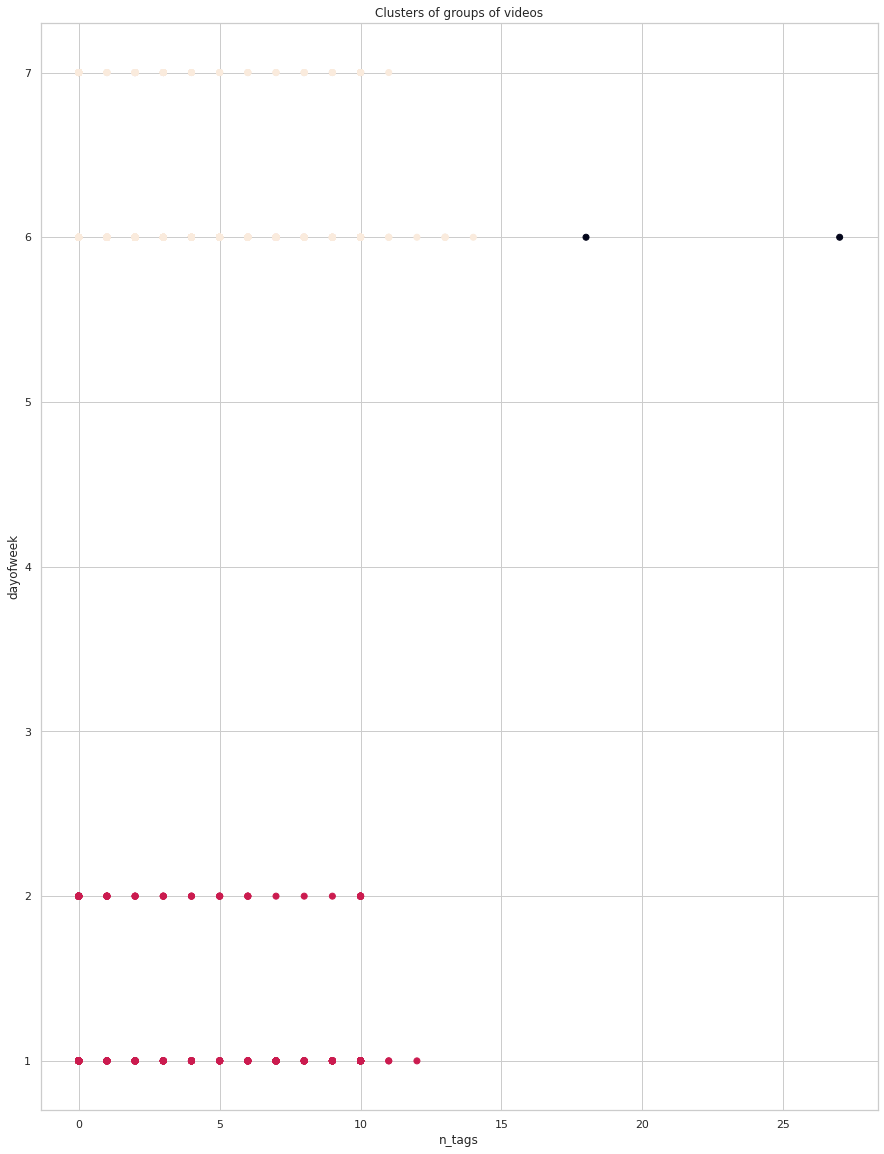

In [106]:
### STILL TO WORK ON 

# define the columns we want to work with
x1 = df.loc[:, ['n_tags', 'dayofweek']].values

# scale the data
scaler = StandardScaler()
scaled_x1 = scaler.fit_transform(x1)

# Instantiate KMeans
dbs = DBSCAN(eps = 0.5, min_samples = 5).fit(scaled_x1)
dbs.fit(scaled_x1)

df['cluster1'] = dbs.labels_

# Visualize the clusters
plt.scatter(df['n_tags'], df['dayofweek'], c = df['cluster1'])
plt.xlabel('n_tags')
plt.ylabel('dayofweek')
plt.title('Clusters of groups of videos');